<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2
</center>
Авторы материала: аспирант Мехмата МГУ Евгений Колмаков, программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 3. Опциональная часть 
## <center> Реализация алгоритма построения дерева решений

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.base import BaseEstimator
from sklearn.datasets import make_classification, make_regression, load_digits, load_boston
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error

**Необходимо реализовать класс `DecisionTree`**

**Спецификация:**
- класс наследуется от `sklearn.BaseEstimator`;
- конструктор содержит следующие параметры: 
    `max_depth` - максимальная глубина дерева (по умолчанию - `numpy.inf`); 
    `min_samples_split` - минимальное число объектов в вершине, при котором происходит её разбиение (по умолчанию - 2); 
    `criterion` - критерий разбиения (для классификации - 'gini' или 'entropy', для регрессии - 'variance' или 'mad_median'; 
    по умолчанию - 'gini');
    
    Функционал, значение которого максимизируется для поиска оптимального разбиения в данной вершине имеет вид
    $$Q(X, j, t) = F(X) - \dfrac{|X_l|}{|X|} F(X_l) - \dfrac{|X_r|}{|X|} F(X_r),$$
    где $X$ - выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ - разбиение выборки $X$ на две части 
    по предикату $[x_j < t]$, а $F(X)$ -критерий разбиения.
    
    Для классификации: пусть $p_i$ - доля объектов $i$-го класса в выборке $X$.
    
    'gini': Неопределенность Джини $F(X) = 1 -\sum_{i = 1}^K p_i^2$.
    
    'entropy': Энтропия $F(X) = -\sum_{i = 1}^K p_i \log_2(p_i)$.
    
    Для регрессии: $y_j = y(x_j)$ - ответ на объекте $x_j$, $y = (y_1, \dots, y_{|X|})$ - вектор ответов.
    
    'variance': Дисперсия (среднее квадратичное отклонение от среднего) $F(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j - \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2$
    
    'mad_median': Среднее отклонение от медианы $F(X) = \dfrac{1}{|X|} \sum_{x_j \in X}|y_j - \mathrm{med}(y)|$
    
- класс имеет методы `fit`, `predict` и `predict_proba`;
- метод `fit` принимает матрицу объектов `X` и вектор ответов `y` (объекты `numpy.ndarray`) и возвращает экземпляр класса
    `DecisionTree`, представляющий собой решающее дерево, обученное по выборке `(X, y)` с учётом заданных в конструкторе параметров; 
- метод `predict_proba` принимает матрицу объектов `X` и возвращает матрицу `P` размера `X.shape[0] x K`, где `K` - число классов, такую что $p_{ij}$ есть вероятность принадлежности объекта, заданного $i$-ой строкой матрицы X к классу $j \in \{1, \dots, K\}$.
- метод `predict` принимает матрицу объектов и возвращает вектор предсказанных ответов; в случае классификации - это 
    наиболее многочисленный класс в листе, в который попал объект, а в случае регрессии - среднее значение ответов по 
    всем объектам этого листа;

In [2]:
# Определим критерии качества: 
# энтропийный критерий и критерий Джини - для классификации
def entropy(y):    
    p = [len(y[y == k]) / len(y) for k in np.unique(y)]
    return -np.dot(p, np.log2(p))

def gini(y):
    p = [len(y[y == k]) / len(y) for k in np.unique(y)]
    return 1 - np.dot(p, p)

# дисперсионный критерий и медианный критерий - для регрессии
def variance(y):
    return np.var(y)

def mad_median(y):
    return np.mean(np.abs(y - np.median(y)))

criteria_dict = {'entropy': entropy, 'gini': gini, 
                 'variance': variance, 'mad_median': mad_median}

Класс Node реализует вершину в дереве решений.

In [3]:
class Node():
    
    def __init__(self, feature_idx=0, threshold=0, labels=None, left=None, right=None):
        self.feature_idx = feature_idx
        self.threshold = threshold
        self.labels = labels
        self.left = left
        self.right = right

Определяем функцию для вычисления ответа в листе. Для регрессии берем среднее по всем объектам в листе, для классификации – наиболее многочисленный класс в листе

In [4]:
def regression_leaf(y):
    return np.mean(y)

def classification_leaf(y):
    return np.bincount(y).argmax()

In [5]:
class DecisionTree(BaseEstimator):
    
    def __init__(self, max_depth=np.inf, min_samples_split=2, 
                 criterion='gini', debug=False):
        # Инициализируем объект с помощью метода set_params
        params = {'max_depth': max_depth,
                  'min_samples_split': min_samples_split,
                  'criterion': criterion,
                  'debug': debug}
        
        self.set_params(**params)
        
        if self.debug:
            print("\nDecisionTree params:")
            print("max_depth = {}, min_samples_split = {}, criterion = {}\n"\
                  .format(max_depth, min_samples_split, criterion))
            
    def set_params(self, **params):
        super(DecisionTree, self).set_params(**params)
        
        self._criterion_function = criteria_dict[self.criterion]
        
        if self.criterion in ['variance', 'mad_median']:
            self._leaf_value = regression_leaf
        else:
            self._leaf_value = classification_leaf
        
        return self
            
    
    # Функционал, на основе которого осуществляется разбиение выборки на две части
    def _functional(self, X, y, feature_idx, threshold):
        mask = X[:, feature_idx] > threshold
        n_obj = X.shape[0]
        n_right = np.sum(mask)
        n_left = n_obj - n_right    
        if n_left > 0 and n_right > 0:
            return self._criterion_function(y) - (n_left / n_obj) * \
                    self._criterion_function(y[~mask]) - (n_right / n_obj) * \
                    self._criterion_function(y[mask])
        else:
            return 0
        
    # Рекурсивная процедура построения дерева решений 
    def _build_tree(self, X, y, depth=0):
        max_functional = 0
        best_feature_idx = None
        best_threshold = None
        n_samples, n_features = X.shape     
        
        
        # Если все объекты в текущей вершине имеют одинаковые значения ответов, 
        # то значение функционала также будет = 0 при всех разбиениях. 
        # Значит, в этом случае вершина - лист, поэтому чтобы не производить
        # лишних вычислений, делаем эту проверку перед основным циклом.
        if len(np.unique(y)) == 1:
            return Node(labels=y)
            
        # Если критерий останова не выполнен, то ищем оптимальное разбиение
        if depth < self.max_depth and n_samples >= self.min_samples_split:
            if self.debug:
                print("depth = {}, n_samples = {}".format(depth, n_samples))
                
            # Перебираем все признаки...
            for feature_idx in range(n_features):
                # и все пороги для фиксированного признака
                threshold_values = np.unique(X[:, feature_idx])    
                functional_values = [self._functional(X, y, feature_idx, threshold) 
                                     for threshold in threshold_values]
                
                best_threshold_idx = np.nanargmax(functional_values)
                    
                if functional_values[best_threshold_idx] > max_functional:
                    max_functional = functional_values[best_threshold_idx]
                    best_threshold = threshold_values[best_threshold_idx]
                    best_feature_idx = feature_idx
                    best_mask = X[:, feature_idx] > best_threshold
    
        if best_feature_idx is not None:
            if self.debug:
                print("best feature = {}, best threshold = {}"\
                      .format(best_feature_idx, best_threshold))
            # Если разбиение произошло, идем дальше рекурсивно...
            return Node(feature_idx=best_feature_idx, threshold=best_threshold, 
                        left=self._build_tree(X[~best_mask, :], y[~best_mask], depth + 1),
                        right=self._build_tree(X[best_mask, :], y[best_mask], depth + 1))
        else:
            # иначе, наша вершина - лист, выходим из рекурсии
            return Node(labels=y)
    
    
    def fit(self, X, y):
        # В случае задачи классификации запоминаем число классов
        if self.criterion in ['gini', 'entropy']:
            self._n_classes = len(np.unique(y))
            
        self.root = self._build_tree(X, y)
        
        return self
    
    # Предсказание ответа для одного объекта
    def _predict_object(self, x, node=None):
        
        node = self.root
        # Идём от корня, пока не придём в лист
        while node.labels is None:
            if x[node.feature_idx] > node.threshold:
                node = node.right
            else:
                node = node.left
        # Вычисляем ответ
        return self._leaf_value(node.labels)

        
    def predict(self, X):
        return np.array([self._predict_object(x) for x in X]) 
    
    def _predict_proba_object(self, x, node=None):
        
        node = self.root
        # Идём от корня, пока не придём в лист
        while node.labels is None:
            if x[node.feature_idx] > node.threshold:
                node = node.right
            else:
                node = node.left
        # Вычисляем вероятности принадлежности к классам
        return [len(node.labels[node.labels == k]) / \
                len(node.labels) for k in range(self._n_classes)]
        
        
    def predict_proba(self, X):
        return np.array([self._predict_proba_object(x) for x in X])

## Тестирование реализованного алгоритма

### Классификация

Протестируем наш класс на искусственной выборке. Убедимся, что `predict_proba` работает правильно. 

Accuracy: 0.866666666667
predict_proba works!


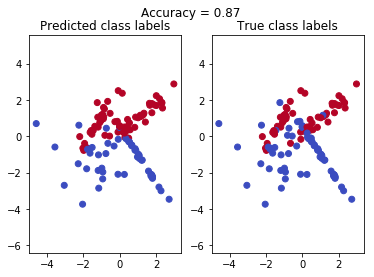

In [6]:
X, y = make_classification(n_features=2, n_redundant=0, n_samples=400,
                          random_state=17)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

clf = DecisionTree(max_depth=4, criterion='gini')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
prob_pred = clf.predict_proba(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)

if (sum(np.argmax(prob_pred,axis=1) - y_pred) == 0):
    print('predict_proba works!')

plt.suptitle("Accuracy = {0:.2f}".format(accuracy))
plt.subplot(121)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred, cmap=plt.cm.coolwarm)
plt.title('Predicted class labels')
plt.axis('equal')
plt.subplot(122)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.coolwarm)
plt.title('True class labels')
plt.axis('equal');

С помощью метода `load_digits` загрузите датасет `digits`. Разделите выборку на обучающую и тестовую с помощью метода `train_test_split`, используйте значения параметров `test_size=0.2`, `random_state=17`. Попробуйте обучить неглубокие решающие деревья и убедитесь, что критерии gini и entropy дают разные результаты.

In [7]:
digits = load_digits()

X = digits.data
y = digits.target

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                            test_size=0.2, random_state=11)

clf1 = DecisionTree(max_depth=2, criterion='gini', debug=True)
clf1.fit(X_train, y_train)

print(accuracy_score(clf1.predict(X_test), y_test))


clf2 = DecisionTree(max_depth=2, criterion='entropy', debug=True)
clf2.fit(X_train, y_train)

print(accuracy_score(clf2.predict(X_test), y_test))


DecisionTree params:
max_depth = 2, min_samples_split = 2, criterion = gini

depth = 0, n_samples = 1437
best feature = 36, best threshold = 0.0
depth = 1, n_samples = 220
best feature = 42, best threshold = 4.0
depth = 1, n_samples = 1217
best feature = 21, best threshold = 0.0
0.3

DecisionTree params:
max_depth = 2, min_samples_split = 2, criterion = entropy

depth = 0, n_samples = 1437
best feature = 21, best threshold = 1.0
depth = 1, n_samples = 431
best feature = 42, best threshold = 9.0
depth = 1, n_samples = 1006
best feature = 36, best threshold = 2.0
0.341666666667


С помощью 5-кратной кросс-валидации (`GridSearchCV`) подберите оптимальное значение параметров `max_depth` и `criterion`. Для параметра `max_depth` используйте диапазон значений – `range(3, 11)`, а для criterion - {'gini', 'entropy'}. Критерий качества `scoring`='accuracy'.

In [8]:
tree_params = {'max_depth': list(range(3, 11)), 
               'criterion': ['gini', 'entropy']}

clf = GridSearchCV(DecisionTree(), tree_params, cv=5, scoring='accuracy') 

clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTree(criterion='gini', debug=False, max_depth=inf,
       min_samples_split=2),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9, 10], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

Постройте графики средних значений критерия качества `accuracy` для критериев `gini` и `entropy` в зависимости от `max_depth`.

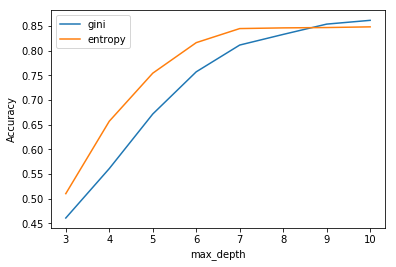

In [9]:
scores = np.array(clf.cv_results_['mean_test_score'])
scores = scores.reshape(len(tree_params['criterion']), 
                        len(tree_params['max_depth']))

for ind, i in enumerate(tree_params['criterion']):
    plt.plot(tree_params['max_depth'], scores[ind], label=str(i))
plt.legend(loc='best')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.show();

**Выберите верные утверждения:**
1. Оптимальное значение max_depth для каждого критерия достигается внутри отрезка [3, 10] (то есть на отрезке [4, 9]).
2. На отрезке [3, 10] построенные графики не пересекаются.
3. **<font color='green'>На отрезке [3, 10] построенные графики пересекаются ровно один раз.</font>**
4. **<font color='green'>Наилучшее качество при max_depth на интервале [3, 10] достигается на критерии gini.</font>**
5. **<font color='green'>Хотя бы для одного из критериев значение accuracy строго возрастает с ростом значения max_depth на интервале [3, 10].</font>**

**Чему равны найденные оптимальные значения параметров max_depth и criterion?**
1. max_depth = 4, criterion = 'gini';
2. max_depth = 7, criterion = 'entropy';
3. max_depth = 10, criterion = 'entropy';
4. **<font color='green'>max_depth = 10, criterion = 'gini';</font>**
5. max_depth = 3, criterion = 'entropy';
6. max_depth = 9, criterion = 'gini';

Используя найденные оптимальные значения max_depth и criterion, обучите решающее дерево на X_train, y_train и вычислите вероятности принадлежности к классам для X_test.

In [10]:
clf = DecisionTree(max_depth=10, criterion='gini')
clf.fit(X_train, y_train)
probs = clf.predict_proba(X_test)

Для полученной матрицы вычислите усредненные по всем объектам из `X_test` значения вероятностей принадлежности к классам.

In [11]:
mean_probs = np.mean(probs, axis=0)
print(mean_probs)

[ 0.09444444  0.11218791  0.0875      0.11783761  0.10138889  0.09734848
  0.09166667  0.08277778  0.10642376  0.10842446]


**Вопрос:** Чему равна максимальная вероятность в полученном векторе?
1. 0.11218791
2. **<font color='green'>0.11783761</font>**
3. 1.0
4. 0.0875

### Регрессия

Проделаем то же самое для регрессии.

Mean Squared Error: 51.3868058963


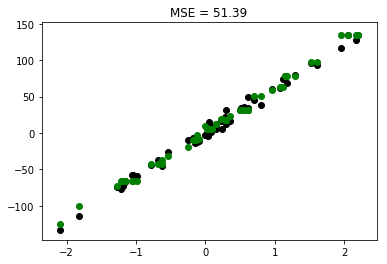

In [13]:
X, y = make_regression(n_features=1, n_samples=200, bias=0, noise=5,
                      random_state=17)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

reg = DecisionTree(max_depth=6, criterion='mad_median')
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

plt.scatter(X_test[:, 0], y_test, color='black')
plt.scatter(X_test[:, 0], y_pred, color='green')
plt.title("MSE = {0:.2f}".format(mse));

С помощью метода `load_boston` загрузите датасет `boston`. Разделите выборку на обучающую и тестовую с помощью метода `train_test_split`, используйте значения параметров `test_size=0.2`, `random_state=17`. Попробуйте обучить неглубокие регрессионные деревья и убедитесь, что критерии `variance` и `mad_median` дают разные результаты.

In [14]:
boston = load_boston()

X = boston.data
y = boston.target

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                            test_size=0.2, random_state=11)

clf1 = DecisionTree(max_depth=2, criterion='variance', debug=True)
clf1.fit(X_train, y_train)

print(mean_squared_error(clf1.predict(X_test), y_test))


clf2 = DecisionTree(max_depth=2, criterion='mad_median', debug=True)
clf2.fit(X_train, y_train)

print(mean_squared_error(clf2.predict(X_test), y_test))


DecisionTree params:
max_depth = 2, min_samples_split = 2, criterion = variance

depth = 0, n_samples = 404
best feature = 5, best threshold = 6.976
depth = 1, n_samples = 350
best feature = 12, best threshold = 14.37
depth = 1, n_samples = 54
best feature = 5, best threshold = 7.42
34.913983248

DecisionTree params:
max_depth = 2, min_samples_split = 2, criterion = mad_median

depth = 0, n_samples = 404
best feature = 5, best threshold = 6.794
depth = 1, n_samples = 332
best feature = 12, best threshold = 14.98
depth = 1, n_samples = 72
best feature = 5, best threshold = 7.42
32.3968245462


С помощью 5-кратной кросс-валидации подберите оптимальное значение параметров `max_depth` и `criterion`. Для параметра `max_depth` используйте диапазон значений - `range(2, 9)`, а для `criterion` - {'variance', 'mad_median'}. Критерий качества `scoring`='neg_mean_squared_error'.

In [15]:
%%time
tree_params = {'max_depth': list(range(2, 9)), 
               'criterion': ['variance', 'mad_median']}

reg = GridSearchCV(DecisionTree(), tree_params, 
                   cv=5, scoring='neg_mean_squared_error')

reg.fit(X_train, y_train)

CPU times: user 1min 15s, sys: 167 ms, total: 1min 16s
Wall time: 1min 16s


Постройте графики средних значений критерия качества `neg_mean_squared_error` для критериев `variance` и `mad_median` в зависимости от `max_depth`.

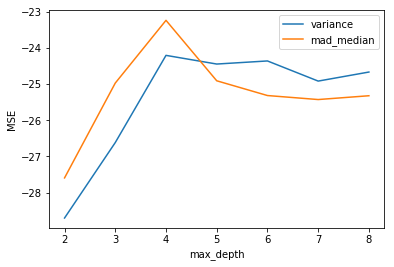

In [16]:
scores = np.array(reg.cv_results_['mean_test_score'])
scores = scores.reshape(len(tree_params['criterion']), len(tree_params['max_depth']))

for ind, i in enumerate(tree_params['criterion']):
    plt.plot(tree_params['max_depth'], scores[ind], label=str(i))
plt.legend()
plt.xlabel('max_depth')
plt.ylabel('MSE')
plt.show();

**Выберите верные утверждения:**
1. На отрезке [2, 8] построенные графики не пересекаются.
2. **<font color='green'>На отрезке [2, 8] построенные графики пересекаются ровно один раз.</font>**
3. Оптимальное значение max_depth для каждого из критериев достигается на границе отрезка [2, 8].
4. Наилучшее качество при max_depth in range(2, 9) достигается на критерии variance.
5. **<font color='green'>График качества ровно для одного из критериев имеет явно выраженный пик.</font>**

**Чему равны найденные оптимальные значения параметров `max_depth` и `criterion`?**
1. max_depth = 9, criterion = 'variance';
2. max_depth = 5, criterion = 'mad_median';
3. max_depth = 4, criterion = 'variance';
4. max_depth = 2, criterion = 'mad_median';
5. **<font color='green'>max_depth = 4, criterion = 'mad_median';</font>**
6. max_depth = 8, criterion = 'variance';

In [17]:
print("Best params:", reg.best_params_)
print("Best cross validaton score", reg.best_score_)

Best params: {'criterion': 'mad_median', 'max_depth': 4}
Best cross validaton score -23.2363120951
